<a href="https://colab.research.google.com/github/ma-ulloa/PSSP/blob/main/PSSP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Protein secondary structure predictor**
Author: Maria Alejandra Ulloa

This predictor uses multilayer feed foward neural networks to predict protein secondary structures taking as input a PSSM.

To find out more of how the model was created follow the link: https://github.com/ma-ulloa/PSSP.git

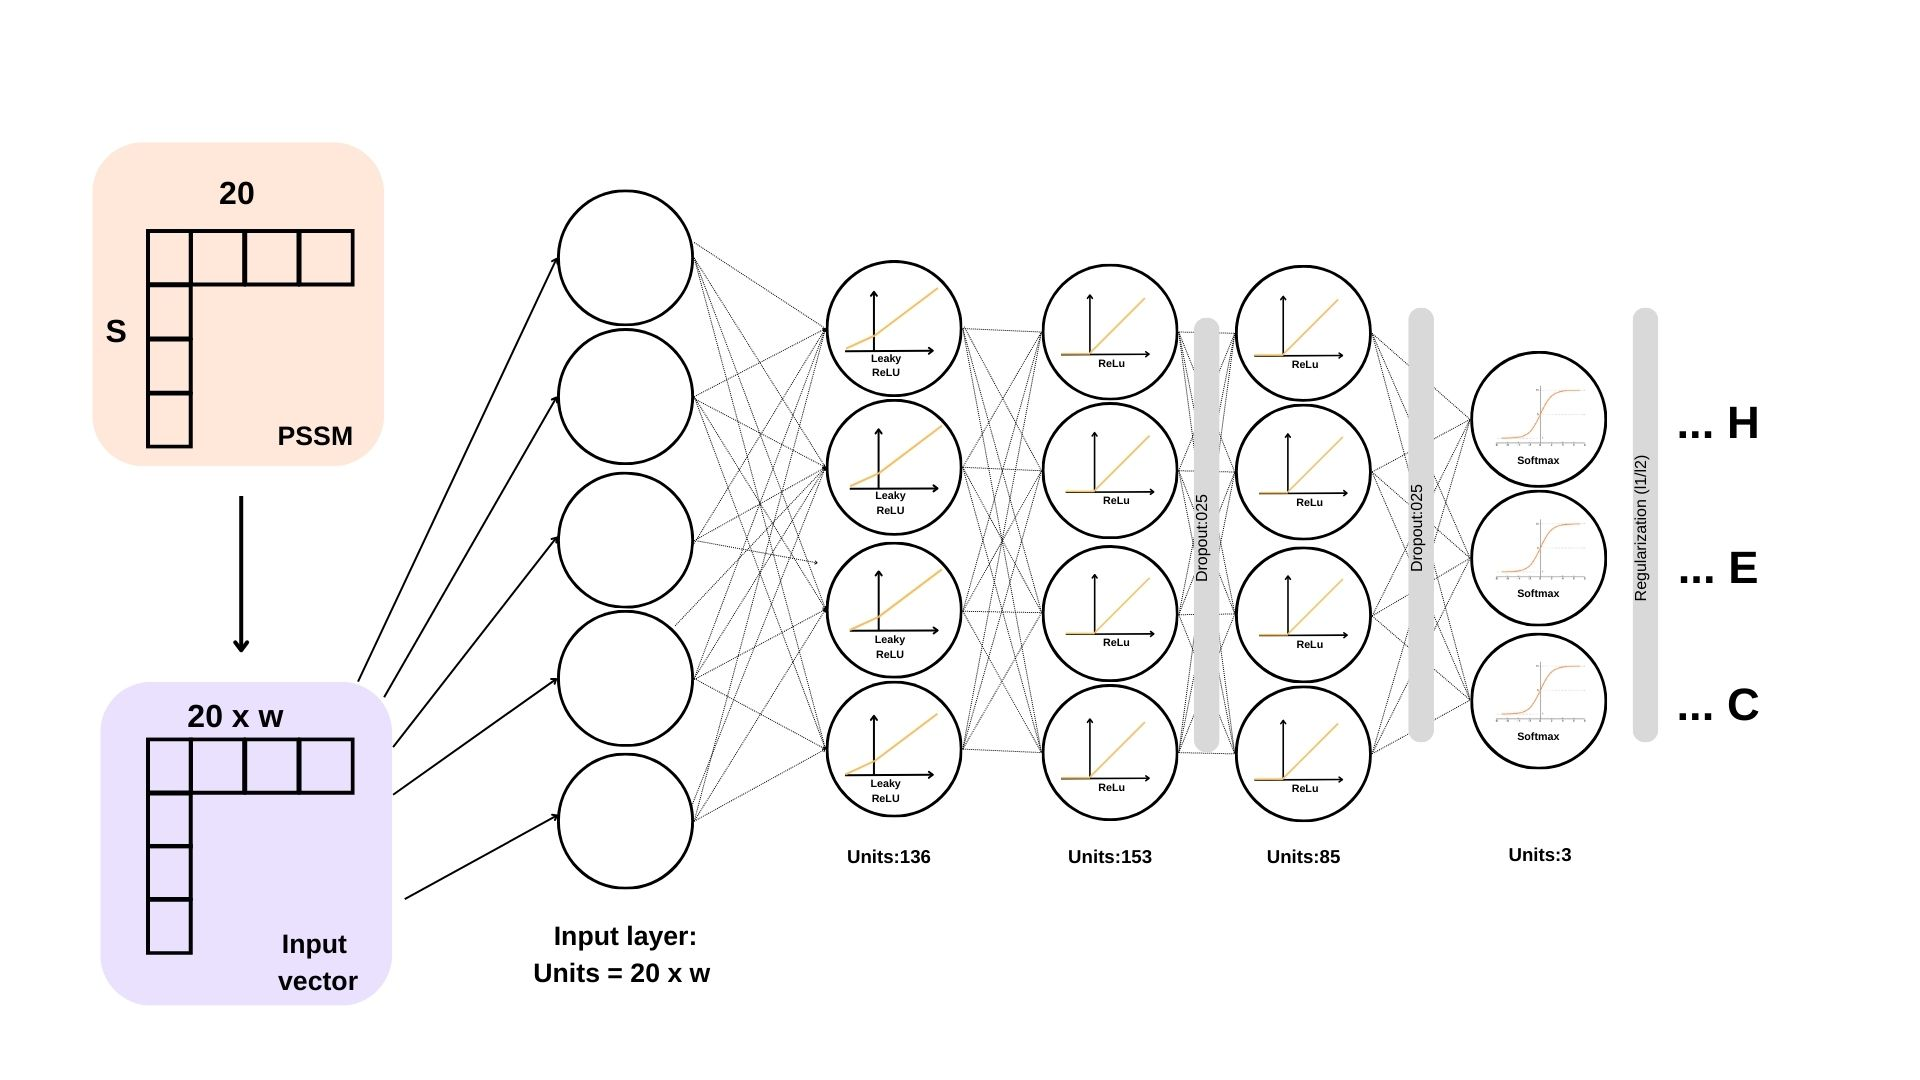

# **Input data**

Please upload the PSSM file for the protein of interest.
1. Click on the file symbol to the left of the screen.

2. Select the “upload” option. Upload the PSSM file.

3. Click on the three dots visible when you hover above the file and copy file path to the cell below.

**Note:** you will see PSSM examples of how your data should be formatted. This pipeline does not handle other types of inputs.

After selecting the parameter of the model and putting your interest sequence you can click "Run all".

In [85]:
# @title
#Import modules
import numpy as np
import scipy.stats as stats
import keras
from keras import layers
from keras.layers import Dense, Flatten, Activation, LeakyReLU, BatchNormalization
from keras import models
from keras import optimizers
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


In [86]:
# @title
# We begin by making a copy of a Github repository which contains all the data required for this lab
# The following code is adapted from Katarina Elez (https://github.com/katarinaelez/protein-ss-pred)

!git clone https://github.com/katarinaelez/protein-ss-pred.git

fatal: destination path 'protein-ss-pred' already exists and is not an empty directory.


In [87]:
# @title
# Feature extraction functions

def parse_pssm(pssm_filename):
	profile = []
	with open(pssm_filename) as pssm:
		pssm_lines = pssm.readlines()
		for line in pssm_lines[3:-6]:
			profile_line = []
			for n in line.rstrip().split()[22:-2]:
				profile_line.append(float(n)/100)
			profile.append(profile_line)
	return profile

def parse_dssp(dssp_filename):
	ss = ''
	with open(dssp_filename) as dssp:
		dssp.readline()
		ss = dssp.readline().rstrip()
	return ss

def seq_to_profile(seq):
	profile = []
	aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
	for res in seq:
		profile_line = []
		for aa in aa_list:
			if res == aa:
				profile_line.append(1)
			else:
				profile_line.append(0)
		profile.append(profile_line)
	return profile

def profiles(profile, x_train, y_train, ss_map, window_size, ss):
	for i in range(0, len(profile)):
		half_window_size = int((window_size-1)/2)
		part1 = np.zeros(20*max(0, half_window_size-i))
		part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
		part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
		vec = np.concatenate((part1, part2, part3))
		x_train.append(vec.tolist())
		y_train.append(ss_map[ss[i]])
	return x_train, y_train


# Extract features from pssm files. The features are the pssm values for each
#amino acid in a window of size w. The features are w x 20. The labels are the
# secondary structure of the central amino acid in the window. The labels are
# H, E, C. The labels are converted to numbers 0, 1, and 2, respectively.
#The labels are stored in y_train. The features are stored in x_train.

def extract_features(file_path, pssm_file, dssp_file, window_size):

	with open(file_path) as id_list:
			x_train, y_train = [], []
			ss_map = {'H': 0, 'E': 1, 'C': 2, '-': 2}
			for line in id_list:
				line = line.rstrip()
				if ":" in line:
					line = line.replace(":", "_")
				profile = np.array(parse_pssm(f"{pssm_file}/{line}.pssm"))
				if np.sum(profile) != 0:
					ss = parse_dssp(f"{dssp_file}/{line}.dssp")
					x_train, y_train = profiles(profile, x_train,
												y_train, ss_map,
												window_size, ss)

			x_train, y_train = np.array(x_train), np.array(y_train)
			y_train = keras.utils.to_categorical(y_train, 3) # Create one-hot encoding for the labels

	return x_train, y_train

def user_profiles(profile, window_size):
	profile_user = []
	for i in range(0, len(profile)):
		half_window_size = int((window_size-1)/2)
		part1 = np.zeros(20*max(0, half_window_size-i))
		part2 = np.ndarray.flatten(profile[max(0,i-half_window_size):min(i+half_window_size+1,len(profile))])
		part3 = np.zeros(20*max(0, half_window_size-(len(profile)-i-1)))
		vec = np.concatenate((part1, part2, part3))
		profile_user.append(vec.tolist())

	return profile_user

def extract_user_features(file_path, window_size):
	profile = np.array(parse_pssm(file_path))
	if np.sum(profile) != 0:
		user_data = user_profiles(profile, window_size)

	user_data = np.array(user_data)
	return user_data


def convert(probs_array):
    sequence = ''
    probabilities = []
    for prob in probs_array:
        max_prob_index = np.argmax(prob)
        probabilities.append(prob[max_prob_index])
        if max_prob_index == 0:
            sequence += 'H'  # Helix
        elif max_prob_index == 1:
            sequence += 'E'  # Sheet
        else:
            sequence += 'C'  # Coil
    return sequence, probabilities

def plot_sequence(sequence, probabilities):
    # Create a color map for each class
    colors = {'H': 'blue', 'E': 'green', 'C': 'red'}
    # Convert sequence to uppercase
    sequence = sequence.upper()
    # Create a figure
    fig, ax = plt.subplots(figsize=(25, 1))
    # Plot each character in the sequence with corresponding color
    for i, char in enumerate(sequence):
        ax.text(i, 0, char, color=colors[char], ha='center', fontsize=8)
    # Plot a heatmap of probabilities below the sequence
    ax.imshow([probabilities], cmap='coolwarm', aspect='auto', extent=[-0.5, len(sequence) - 0.2, -1, -0.2])
    # Set plot limits and remove axes
    ax.set_xlim(-0.5, len(sequence) - 0.5)
    ax.set_ylim(-1, 1)
    ax.axis('off')

    # Show the plot
    plt.show()


In [88]:
# @title
# Training data

def cv_features(window_size):
    cv_train, cv_train_ss, cv_test, cv_test_ss = [], [], [], []
    id_list = [["train1", "test1"],
            ["train2", "test2"],
            ["train3", "test3"],
            ["train4", "test4"],
            ["train5", "test5"]]

    for train, test in id_list:
        train_path=f"/content/protein-ss-pred/data/training/cv/{train}.txt"
        test_path =f"/content/protein-ss-pred/data/training/cv/{test}.txt"
        pssm_files = "/content/protein-ss-pred/data/training/pssm"
        dssp_files = "/content/protein-ss-pred/data/training/dssp"

        x_train, y_train = extract_features(train_path, pssm_files, dssp_files, window_size)
        x_test, y_test = extract_features(test_path, pssm_files, dssp_files, window_size)
        print(f"Features and labels extracted: {train} and {test}")
        cv_train.append(x_train)
        cv_train_ss.append(y_train)
        cv_test.append(x_test)
        cv_test_ss.append(y_test)

    return cv_train, cv_train_ss, cv_test, cv_test_ss

def print_accuracy_statistics(models):
  '''
  Print the mean and standard deviation of the accuracy
  for the validation sets
  '''
  accuracies = []
  for i in range(len(models)):
      print(f"Validation accuracy for model {i+1}: {models[i]['accuracy']}")
      accuracies = [models[i]['accuracy']]
  accuracy_mean = np.mean(accuracies)
  print(f"Mean accuracy for validation with test data: {accuracy_mean}")

In [89]:
# @title
# Define the model architecture following the best hyperparameters

def cv_model(train_set, train_ss, test_set, ss_test, activation='leaky', regularizer=None, dropout=False):

    # Define the model architecture
    model = keras.Sequential([
        Flatten(input_shape=(train_set.shape[1],)),
    ])

    if activation == 'leaky':
        model.add(layers.Dense(136))
        model.add(LeakyReLU(alpha=0.3))
    elif activation == 'relu':
        model.add(layers.Dense(136, activation='relu'))
    elif activation == 'sigmoid':
        model.add(layers.Dense(136, activation='sigmoid'))
    else:
        raise ValueError("Invalid activation function specified.")

    model.add(layers.Dense(153, activation='relu'))

    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(85, activation='relu'))
    if dropout:
        model.add(layers.Dropout(rate=0.25))

    model.add(layers.Dense(3, activation='softmax'))

    # Add activity regularization if specified
    if regularizer:
        model.add(layers.ActivityRegularization(l1=regularizer, l2=regularizer))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(train_set,
                        train_ss,
                        epochs=4,
                        batch_size=128,
                        validation_split=0.2,
                        verbose=0
                        )

    # Evaluate the model
    loss, accuracy = model.evaluate(test_set, ss_test)
    # Predict with the model
    ss_pred = model.predict(test_set)

    return model, accuracy, loss, history, ss_pred

In [90]:
## Functions
# @title Protein Secondary Structure Predictor training: { display-mode: "form" }
# @markdown Select and odd number between (7-19):
window_size = 17 # @param {type:"integer"}
# @markdown Activation function for first hidden layer:
# @markdown Leaky ReLU, ReLU, or Sigmoid
activation_function = 'leaky' # @param ["leaky", "ReLU", "sigmoid"]
# @markdown L1 and L2 weights for regularization:
regularization = 0.00001 # @param {type:"number"}
# @markdown Select if including dropout in hidden layers:
dropout = True # @param ["False", "True"] {type:"raw"}


# Parsing the pssm file and dssp functions.
cv_train, cv_train_ss, cv_test, cv_test_ss = cv_features(window_size)

# Model results

model_results = []

for i in range(5):
    train_set, train_ss = cv_train[i], cv_train_ss[i]
    test_set, ss_test = cv_test[i], cv_test_ss[i]

    model, accuracy, loss, history, pred = cv_model(train_set,
                                              train_ss,
                                              test_set,
                                              ss_test,
                                              activation=activation_function,
                                              regularizer=regularization,
                                              dropout=dropout)

    model_results.append({
        'model': model,
        'accuracy': accuracy,
        'loss': loss,
        'history': history
    })

# Print accuracy values for models
print_accuracy_statistics(model_results)


Features and labels extracted: train1 and test1
Features and labels extracted: train2 and test2
Features and labels extracted: train3 and test3
Features and labels extracted: train4 and test4
Features and labels extracted: train5 and test5
1239/1239 [==============================] - 2s 2ms/step
Validation accuracy for model 1: 0.7582066655158997
Validation accuracy for model 2: 0.7612323760986328
Validation accuracy for model 3: 0.7500063180923462
Validation accuracy for model 4: 0.7594946622848511
Validation accuracy for model 5: 0.7622531056404114
Mean accuracy for validation with test data: 0.7622531056404114


###**Model selection**
After seeing the accuracy for all cross-validation model. Now, select a model for your protein prediction and enter the PSSM file path.

9/9 [==============================] - 0s 3ms/step
Protein secondary structure:
CCCCEEEEECCCCCCCCCCHHCHCCEHHCCCEEEEEEEEEEECCCCCCCECCCCCCHHHHHHHHHHHHHHCCCCCCCEEEECCCCCHHHHHHHHHHHHHHHCCCCCEEEECCCCCCCCCEECCCHHHHHHHHHCCCCEECCCCHHHHHHHHCCCCCCHHHHHHHHHHHHHCCCCEEEEEECCCCCCCEECCCCCCCCCCCCEEECCCCEEECCCCCCHHHHHHHHHHHHCCCCHHHHHHHHHHHHHHHHHCCCCCCHHHHHHHHHHCCCCCCCEHHHHHHHHHHCCC
-------------------------------------------------------------------------


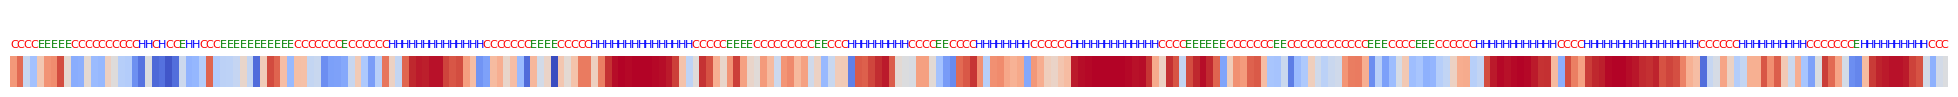

In [91]:
# @markdown ### Enter the file path to the PSSM:
PSSM = "/content/protein-ss-pred/data/blindTest/pssm/4S1H:A.pssm" # @param {type:"string"}
# @markdown ### Enter the model number (1 - 5):
model_number = 5 # @param {type:"integer"}
# @markdown ### Select and odd number between (7-19):
window_size = 17 # @param {type:"integer"}
# @markdown Best accuracy for this model uses a window size of 17

# Access the model for a specific fold (e.g., fold 1)
model_fold = model_results[model_number - 1]['model']

# Format users data
pssm = extract_user_features(PSSM, window_size)

# Make predictions with the model
new_predictions = model_fold.predict(pssm)

# Show sequence and probabilities
# Convert the probabilities to a sequence
sequence, probabilities = convert(new_predictions)

# Print corresponding structure for the sequence
print("Protein secondary structure:")
print(sequence)
print("-------------------------------------------------------------------------")

# plot the sequence
plot_sequence(sequence, probabilities)



